# Customer Segmentation using PySpark

Nhóm thực hiện:
- Nguyễn Thị Bảo Trâm - K204110588
- Võ Nguyên Trúc Lâm - K204110572
- Lê Phước Toàn - K204110586
- Thẩm Thị Tú Uyên - K204111792
- Lê Thảo Giang - K204110562

## Import các thư viện

In [ ]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import * # to create a dataframe of a specific type
from pyspark.sql.functions import * # importig SQL functions
from pyspark.sql.window import Window

In [ ]:
spark = SparkSession.builder.getOrCreate()
spark

## Tiền xử lí dữ liệu

In [ ]:
# import the dataset
data = spark.read.csv("OnlineRetail.csv", inferSchema=True, header=True)

In [ ]:
data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
data.show()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.

In [ ]:
# count the number of rows
print(data.toPandas().shape)

(541909, 8)


In [ ]:
# add TotalAmount column
data = data.withColumn("TotalAmount", data.UnitPrice * data.Quantity)

In [ ]:
data.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|       TotalAmount|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|             20.34|
+---------+---------+---

In [ ]:
# remove duplicates
data = data.dropDuplicates()

In [ ]:
# check null values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+-----------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|TotalAmount|
+---------+---------+-----------+--------+-----------+---------+----------+-------+-----------+
|        0|        0|       1454|       0|          0|        0|    135037|      0|          0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+-----------+



In [ ]:
# remove null values
data = data.na.drop()

In [ ]:
# describe the data
data.describe().show()

+-------+------------------+------------------+--------------------+------------------+---------------+------------------+------------------+-----------+------------------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|         UnitPrice|        CustomerID|    Country|       TotalAmount|
+-------+------------------+------------------+--------------------+------------------+---------------+------------------+------------------+-----------+------------------+
|  count|            401604|            401604|              401604|            401604|         401604|            401604|            401604|     401604|            401604|
|   mean| 560591.0724361651|27434.077076156846|                null|12.183272576966365|           null|3.4740636398046427|15281.160817621338|       null| 20.61363787213252|
| stddev|13087.116746815876|16408.211830026416|                null|  250.283037144454|           null| 69.76403506410998| 1714.0060885

In [ ]:
# remove outliers
data = data.filter(data.Quantity > 0)
data = data.filter(data.UnitPrice > 0)
data = data.filter(data.TotalAmount > 0)

In [ ]:
# check the number of unique values in each column
date_list = data.select([countDistinct(c).alias(c) for c in data.columns])

In [ ]:
data_list = date_list.toPandas().T.reset_index()

In [ ]:
data_list.columns = ["Column", "Count"]

In [ ]:
data_list

,Column,Count
0,InvoiceNo,18532
1,StockCode,3665
2,Description,3877
3,Quantity,301
4,InvoiceDate,17282
5,UnitPrice,440
6,CustomerID,4338
7,Country,37
8,TotalAmount,2939


In [ ]:
data.describe().show()

+-------+------------------+------------------+--------------------+------------------+---------------+------------------+------------------+-----------+------------------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|         UnitPrice|        CustomerID|    Country|       TotalAmount|
+-------+------------------+------------------+--------------------+------------------+---------------+------------------+------------------+-----------+------------------+
|  count|            392692|            392692|              392692|            392692|         392692|            392692|            392692|     392692|            392692|
|   mean| 560590.8750471107|27424.711765258526|                null|  13.1197019547126|           null| 3.125913907082341|15287.843864911942|       null|22.631499735161118|
| stddev|13087.063758993536|16396.667100298742|                null|180.49283198902427|           null|22.241835614051908|1713.53954892

## EDA

In [ ]:
data_pd = data.toPandas()

In [ ]:
# convert invoice date to datetime
data_pd['InvoiceDate'] = pd.to_datetime(data_pd['InvoiceDate'])

In [ ]:
df_temp = data_pd.groupby([data_pd.CustomerID,data_pd.InvoiceDate]).Quantity.sum()
df_temp = pd.DataFrame(df_temp).reset_index()

In [ ]:
df_temp["Hour"]= df_temp["InvoiceDate"].dt.hour
df_temp["Month"]= df_temp["InvoiceDate"].dt.to_period('M')

In [ ]:
count_hours = pd.DataFrame(columns=range(1,25))
count_hours["Month"] = ""

for month in sorted(df_temp["Month"].unique()):
    row = []
    for hour in range(1,25):
        freq = len(df_temp[(df_temp["Month"]==month)&(df_temp["Hour"]==hour)])
        row.append(float(freq))
    row.append(month)
    count_hours.loc[len(count_hours)] = row

count_hours = count_hours.set_index("Month")

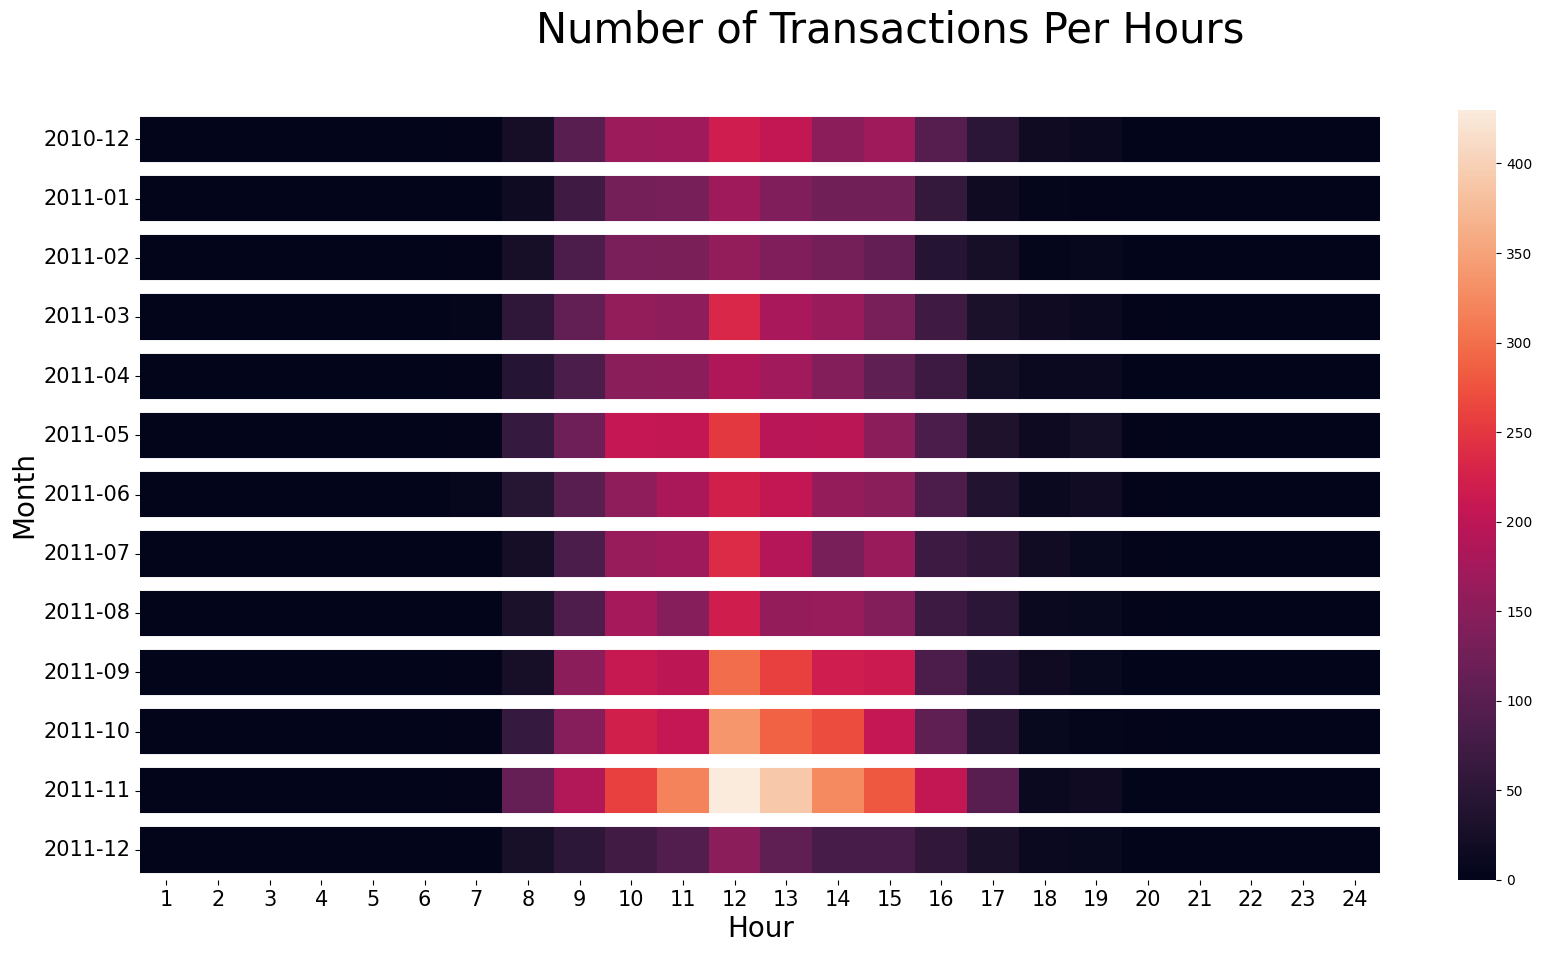

In [ ]:
fig  = plt.figure(figsize = (20,10)).suptitle('Number of Transactions Per Hours', fontsize=30)
heatmap = sns.heatmap(data=count_hours)
plt.yticks(rotation=0,size=15)
plt.xticks(size=15)
heatmap.set_xlabel("Hour",fontsize=20)
heatmap.set_ylabel("Month",fontsize=20)
for i in range(count_hours.shape[1] + 1):
    plt.axhline(i, color='white', lw=10)
plt.show()

Thời điểm từ 10h - 14h có lượt giao dịch nhiều nhất trong ngày

In [ ]:
# visulaze the transactions per month
data_pd['Month'] = data_pd['InvoiceDate'].dt.to_period('M')

<AxesSubplot: title={'center': 'Number of Transactions Per Month'}, xlabel='Month'>

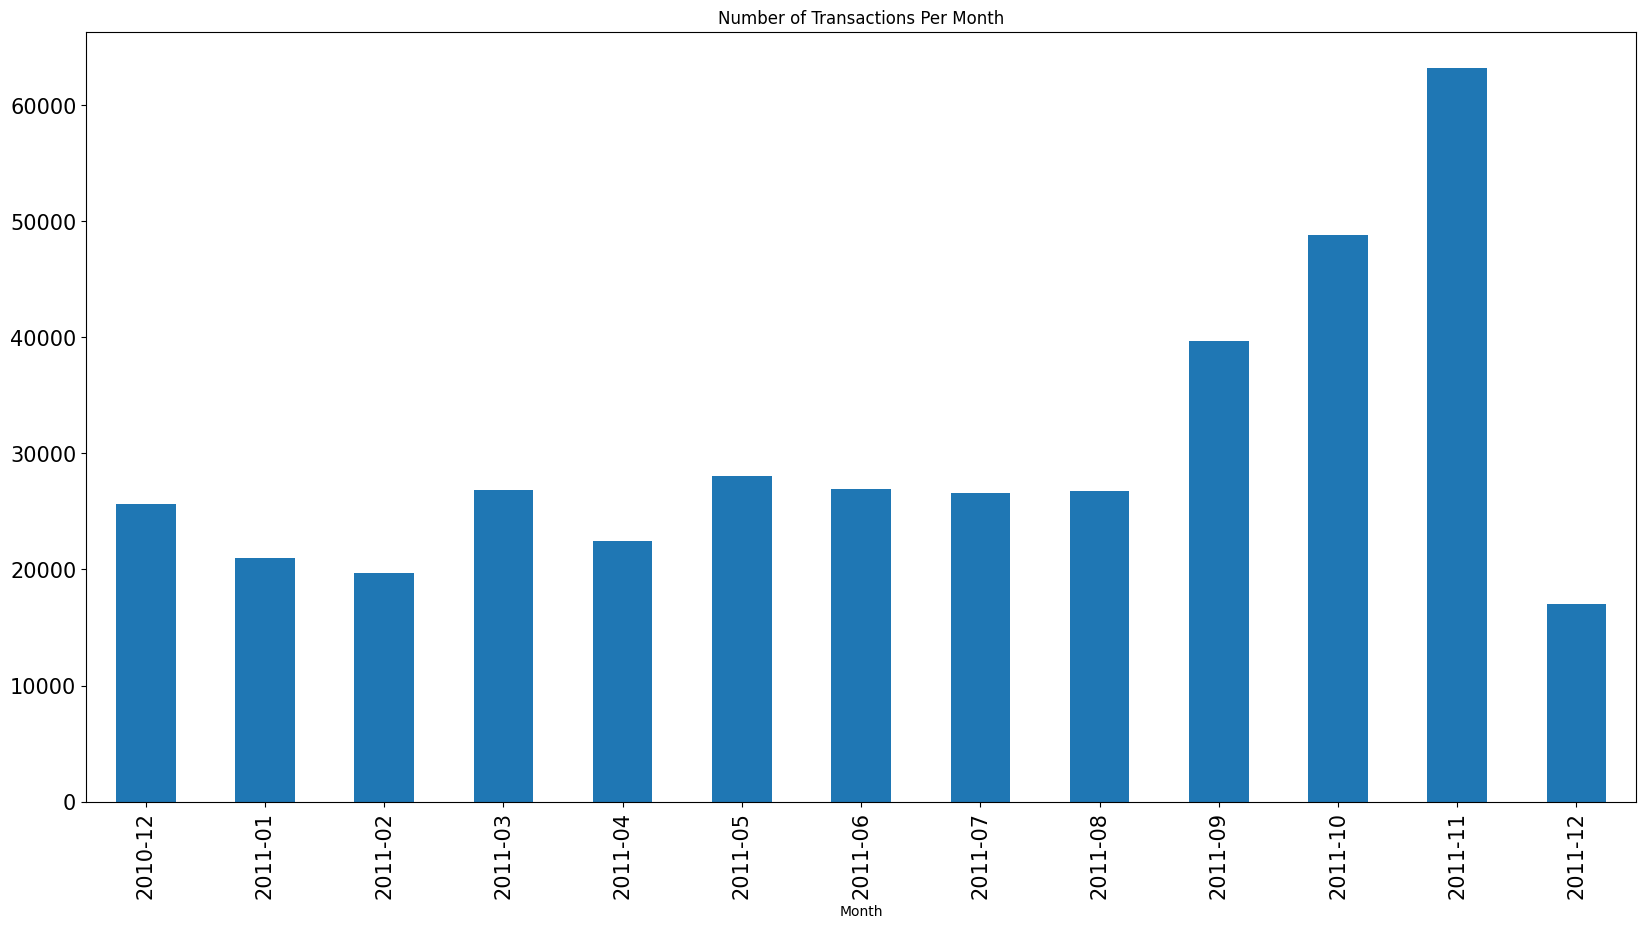

In [ ]:
# plot the bar graph
data_pd.groupby('Month').InvoiceNo.count().plot(kind='bar', figsize=(20,10), title='Number of Transactions Per Month', fontsize=15)

Khoảng tháng 9/2021, số giao dịch tăng mạnh cho đến cuối năm

<AxesSubplot: title={'center': 'Top 10 Countries with the Highest Number of Transactions'}, xlabel='Country'>

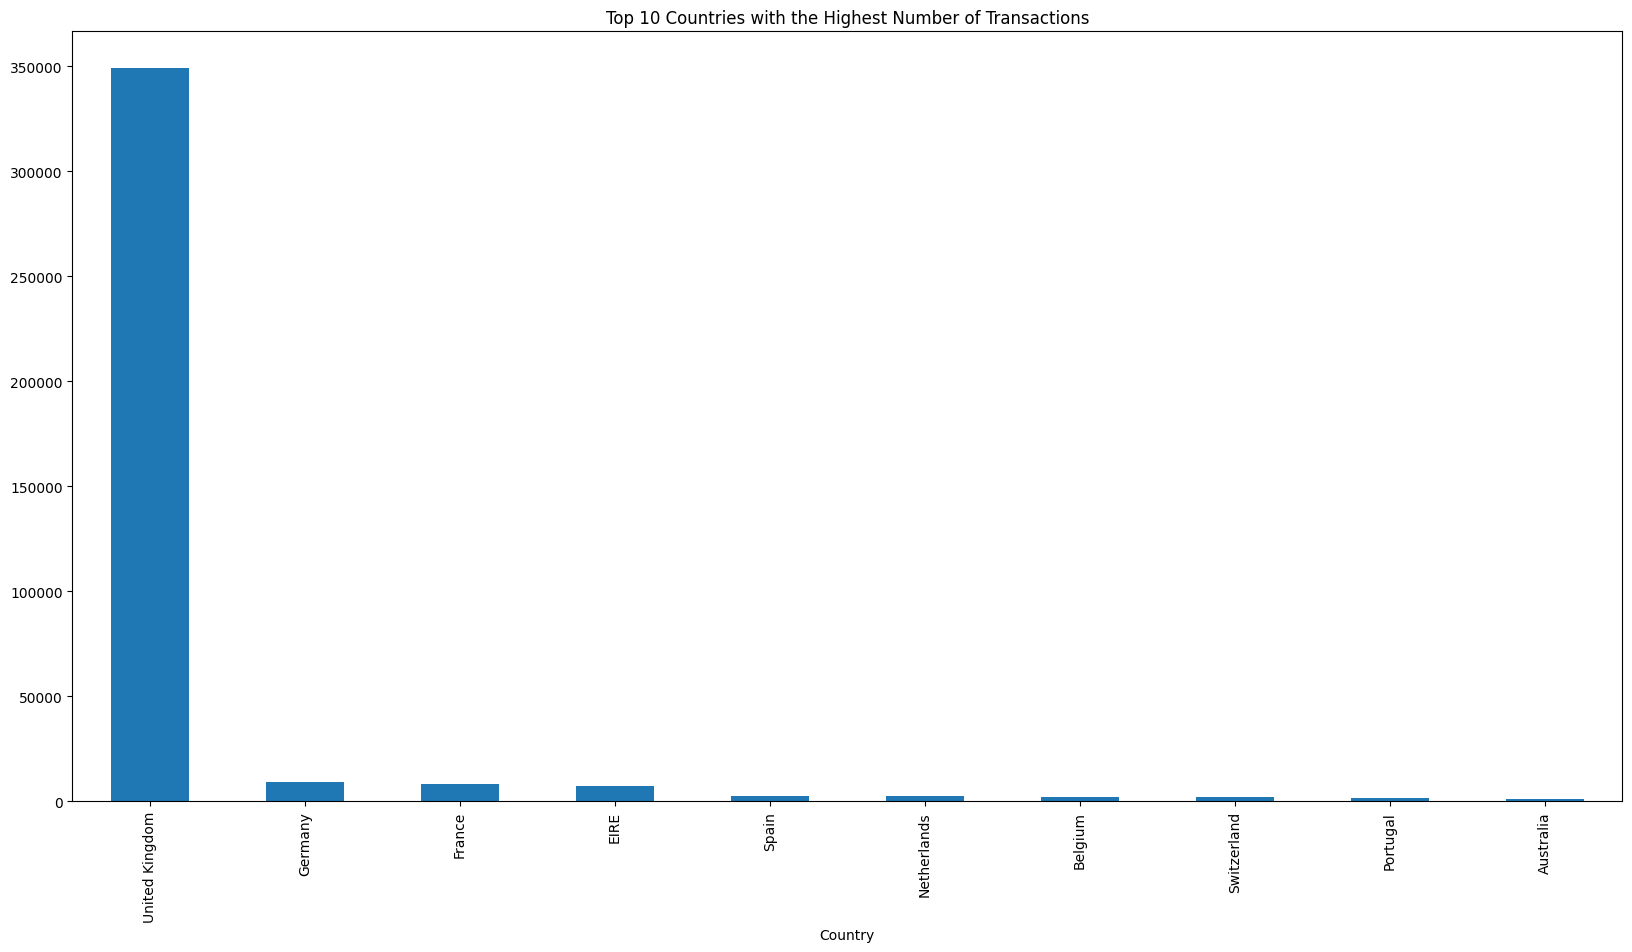

In [ ]:
# top 10 countries with the highest number of transactions
data_pd.groupby('Country').InvoiceNo.count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(20,10), title='Top 10 Countries with the Highest Number of Transactions')

United Kingdom có lượt giao dịch nhiều hơn hẳn so với các nước còn lại

<AxesSubplot: title={'center': 'Top 10 Customers with the Highest Number of Transactions'}, xlabel='CustomerID'>

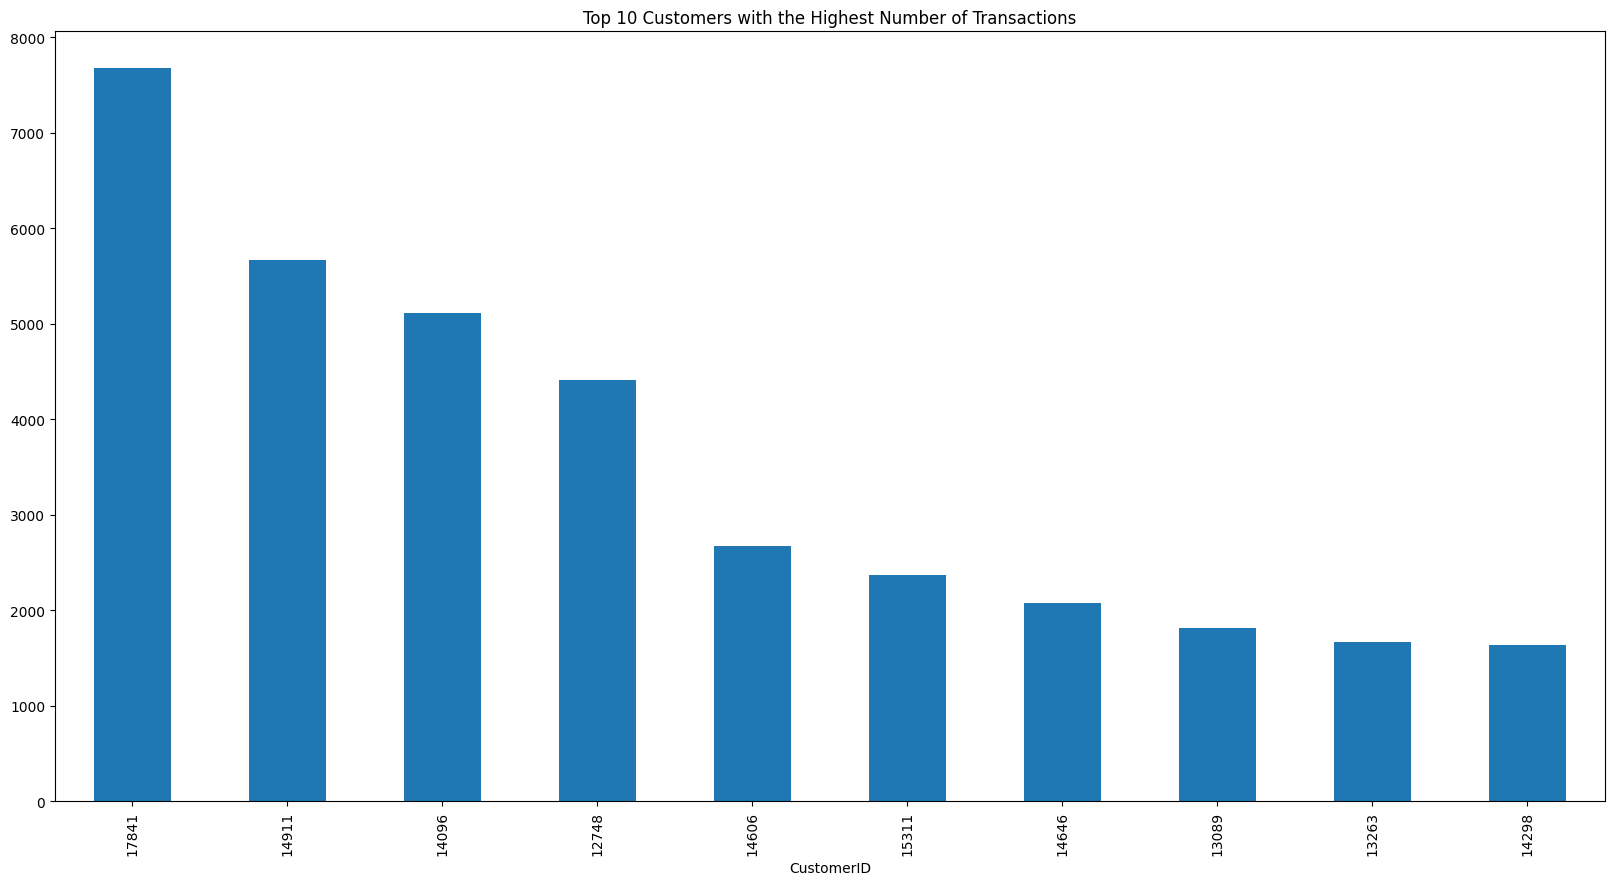

In [ ]:
# visualize the top 10 customers with the highest number of transactions
data_pd.groupby('CustomerID').InvoiceNo.count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(20,10), title='Top 10 Customers with the Highest Number of Transactions')

<AxesSubplot: title={'center': 'Top 10 Products with the Highest Number of Transactions'}, xlabel='Description'>

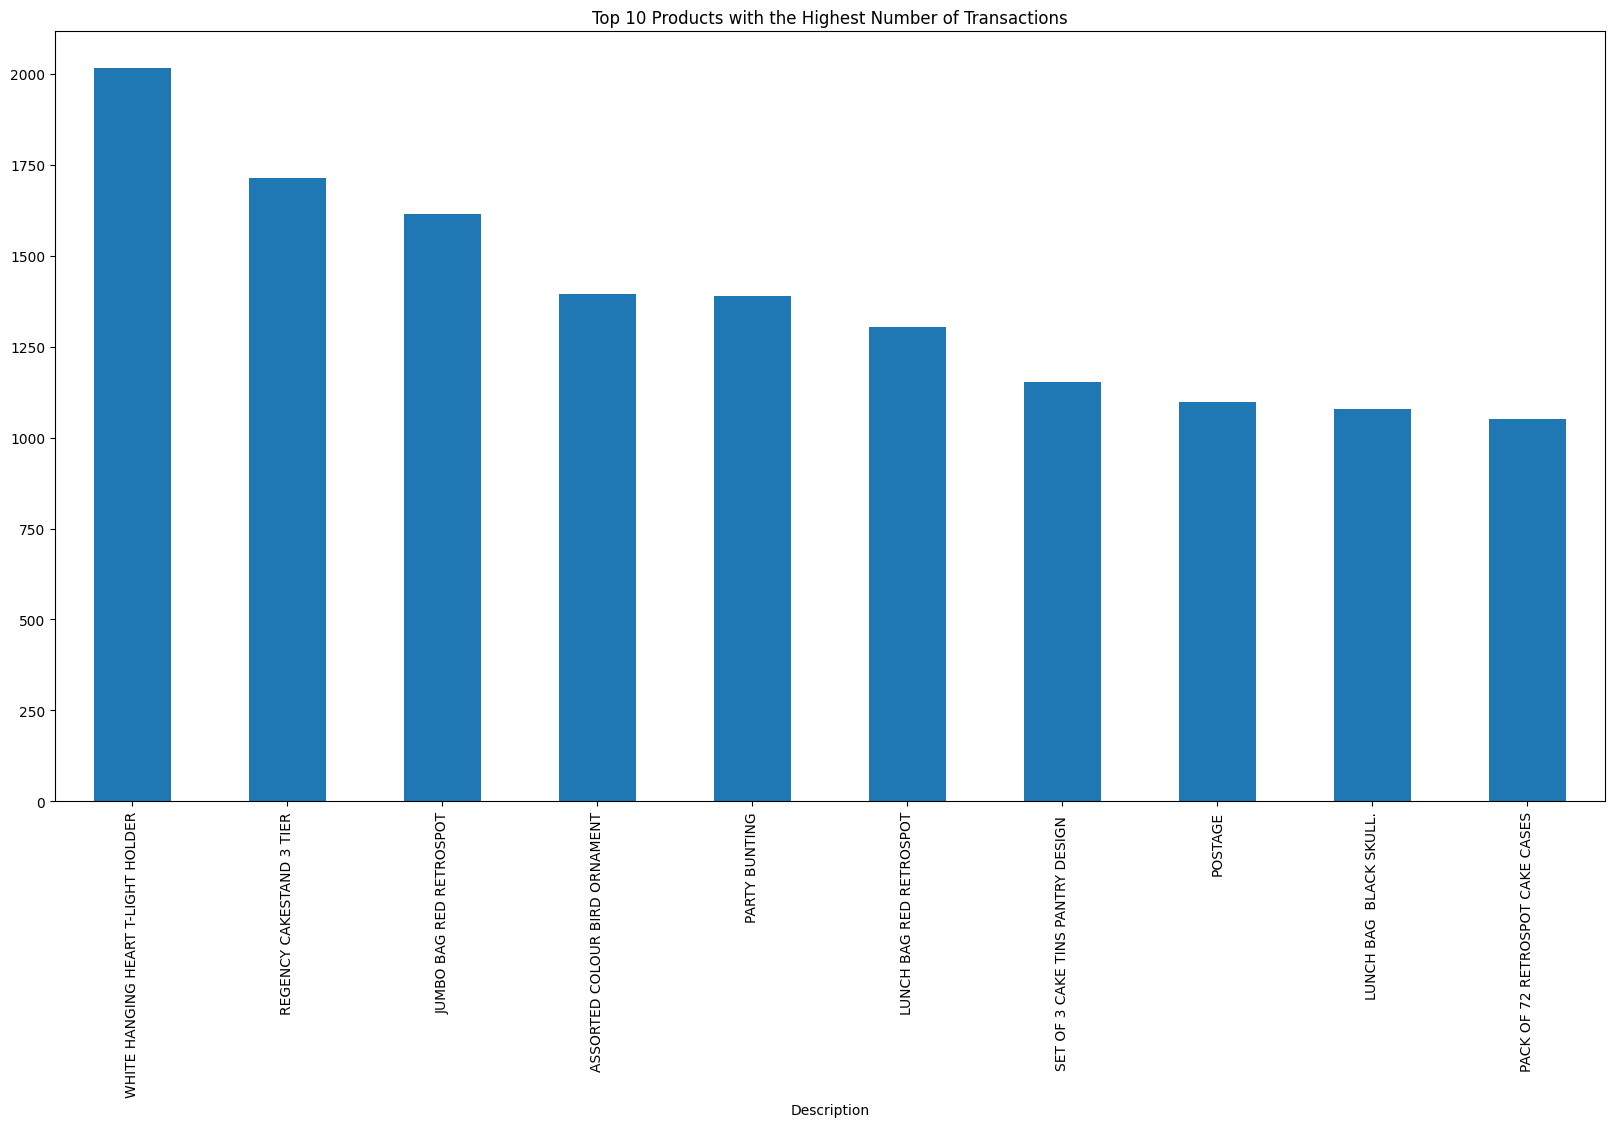

In [ ]:
# top 10 products with the highest number of transactions
data_pd.groupby('Description').InvoiceNo.count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(20,10), title='Top 10 Products with the Highest Number of Transactions')

## RFM

Phân cụm khách hàng ở United Kingdom

In [ ]:
UKdata = data.filter(data.Country == "United Kingdom")

In [ ]:
# check null values
UKdata.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in UKdata.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+-----------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|TotalAmount|
+---------+---------+-----------+--------+-----------+---------+----------+-------+-----------+
|        0|        0|          0|       0|          0|        0|         0|      0|          0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+-----------+



In [ ]:
# convert to pandas dataframe
UKdata_pd = UKdata.toPandas()

In [ ]:
UKdata_pd.describe()

,Quantity,UnitPrice,CustomerID,TotalAmount
count,349203.000000,349203.000000,349203.000000,349203.000000
mean,12.145672,2.972328,15548.384252,20.861862
std,190.628818,17.990908,1594.384044,328.417275
min,1.000000,0.001000,12346.000000,0.001000
25%,2.000000,1.250000,14191.000000,4.200000
50%,4.000000,1.950000,15518.000000,10.200000
75%,12.000000,3.750000,16931.000000,17.850000
max,80995.000000,8142.750000,18287.000000,168469.600000


In [ ]:
# calculate tha last transaction date
UKdata_pd['InvoiceDate'] = pd.to_datetime(UKdata_pd['InvoiceDate'])
LastDate = UKdata_pd['InvoiceDate'].max() + pd.DateOffset(days=1)

In [ ]:
rfm_score = UKdata_pd.groupby('CustomerID').agg({
                                    'InvoiceDate': lambda InvoiceDate: (LastDate - InvoiceDate.max()).days,
                                     'InvoiceNo'    : 'nunique',
                                     'TotalAmount' : 'sum'})
rfm_score.rename(columns={'InvoiceDate': 'Recency','InvoiceNo': 'Frequency','TotalAmount': 'Monetary'}, inplace=True)

In [ ]:
# insert customer id as a column
rfm_score.reset_index(inplace=True)

In [ ]:
rfm_score = spark.read.csv("customer_rfm_numbers.csv", inferSchema=True, header=True)

In [ ]:
rfm_score.show()

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     11|        1|   337.0|
|     17389|      1|       34| 31852.0|
|     14450|    181|        3|   485.0|
|     15727|     17|        7|  5220.0|
|     15790|     11|        1|   225.0|
|     13285|     24|        4|  2741.0|
|     14570|    281|        2|   218.0|
|     16574|     72|        1|   447.0|
|     13832|     20|        1|    52.0|
|     13623|     31|        5|   756.0|
|     15957|     32|        1|   433.0|
|     16503|    107|        4|  1443.0|
|     17679|     53|        2|  1991.0|
|     17420|     51|        3|   603.0|
|     15447|    331|        1|   156.0|
|     16386|     29|        2|   320.0|
|     18024|    153|        2|   391.0|
|     16861|     60|        2|   173.0|
|     16339|    285|        1|   111.0|
|     12940|     55|        2|   923.0|
+----------+-------+---------+--------+
only showing top 20 rows



In [ ]:
rfm_score.describe().show()

+-------+-----------------+-----------------+------------------+------------------+
|summary|       CustomerID|          Recency|         Frequency|          Monetary|
+-------+-----------------+-----------------+------------------+------------------+
|  count|             3921|             3921|              3921|              3921|
|   mean|15561.47156337669|92.72226472838561|4.2461106860494775|1870.6406528946698|
| stddev|1576.823682691171|99.52853214424525| 7.205749957215321|  7485.20727042986|
|    min|            12346|                1|                 1|               0.0|
|    max|            18287|              374|               210|          259665.0|
+-------+-----------------+-----------------+------------------+------------------+



In [ ]:
rfm_score_pd = rfm_score.toPandas()

C:\Users\DELL\AppData\Local\Temp\ipykernel_5564\2605392652.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( rfm_score_pd['Recency'])
C:\Users\DELL\AppData\Local\Temp\ipykernel_5564\2605392652.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( rfm_score_pd['Frequency'])
C:\Users\DELL\AppDat

<AxesSubplot: xlabel='Monetary', ylabel='Density'>

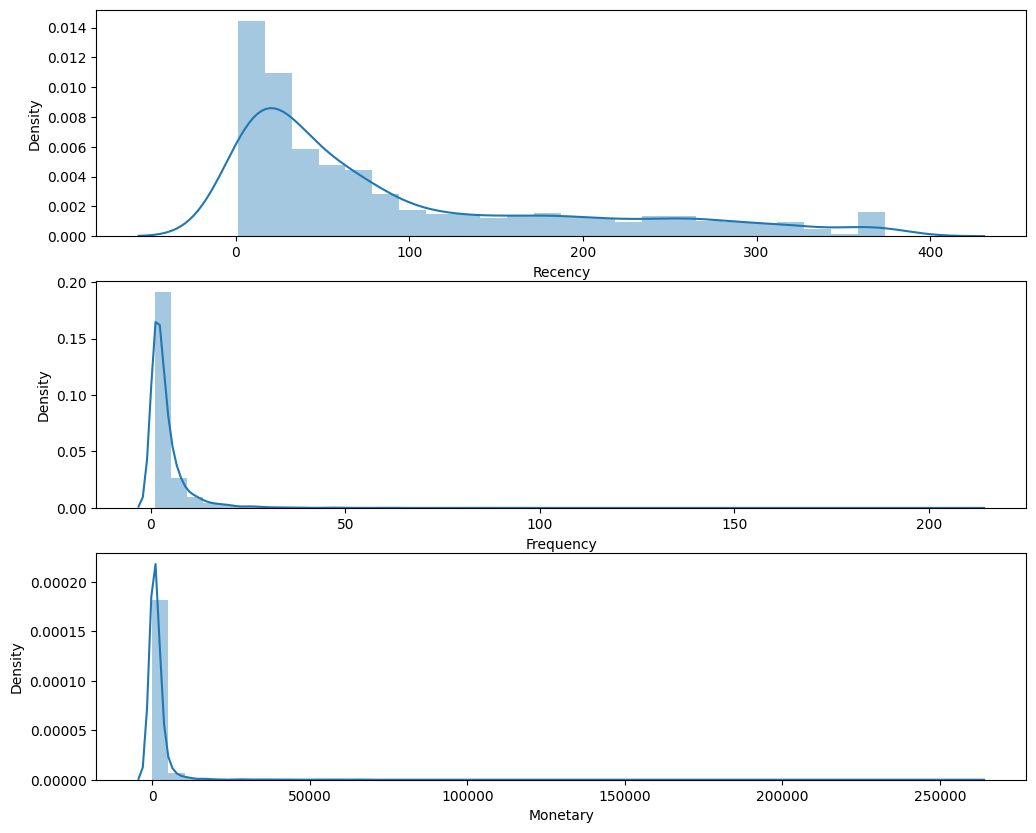

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,10))
# Plot distribution of recency
plt.subplot(3, 1, 1)
sns.distplot( rfm_score_pd['Recency'])
# Plot distribution of frequency
plt.subplot(3, 1, 2)
sns.distplot( rfm_score_pd['Frequency'])
# Plot distribution of monetary
plt.subplot(3, 1, 3)
sns.distplot( rfm_score_pd['Monetary'])

In [ ]:
# remove zero and negative values
rfm_score = (rfm_score.withColumn("Monetary", when(col("Monetary") <= 0, 1).otherwise(col("Monetary"))))

## K-Means clustering

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

### Vectorize

In [ ]:
features = rfm_score.columns[1:]

In [ ]:
# vectorize all features
assembler = VectorAssembler(inputCols=features, outputCol="rfm_features")
assembled_data = assembler.transform(rfm_score)
assembled_data = assembled_data.select('CustomerID', 'rfm_features')
assembled_data.show(5)

+----------+------------------+
|CustomerID|      rfm_features|
+----------+------------------+
|     15619|  [11.0,1.0,337.0]|
|     17389|[1.0,34.0,31852.0]|
|     14450| [181.0,3.0,485.0]|
|     15727| [17.0,7.0,5220.0]|
|     15790|  [11.0,1.0,225.0]|
+----------+------------------+
only showing top 5 rows



### Standardization

In [ ]:
# Standardization
scaler = StandardScaler(inputCol='rfm_features', outputCol='rfm_standardized')
data_scale = scaler.fit(assembled_data)
scaled_data = data_scale.transform(assembled_data)
scaled_data.show(5)

+----------+------------------+--------------------+
|CustomerID|      rfm_features|    rfm_standardized|
+----------+------------------+--------------------+
|     15619|  [11.0,1.0,337.0]|[0.11052107132513...|
|     17389|[1.0,34.0,31852.0]|[0.01004737012046...|
|     14450| [181.0,3.0,485.0]|[1.81857399180447...|
|     15727| [17.0,7.0,5220.0]|[0.17080529204793...|
|     15790|  [11.0,1.0,225.0]|[0.11052107132513...|
+----------+------------------+--------------------+
only showing top 5 rows



### Using the Elbow Method to find the optimal number of clusters

In [ ]:
costs = np.zeros(10)
# Apply k-means with different value of k
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('rfm_standardized')
    model = kmeans.fit(scaled_data)
    costs[k] = model.summary.trainingCost

Text(0.5, 1.0, 'Elbow Curve')

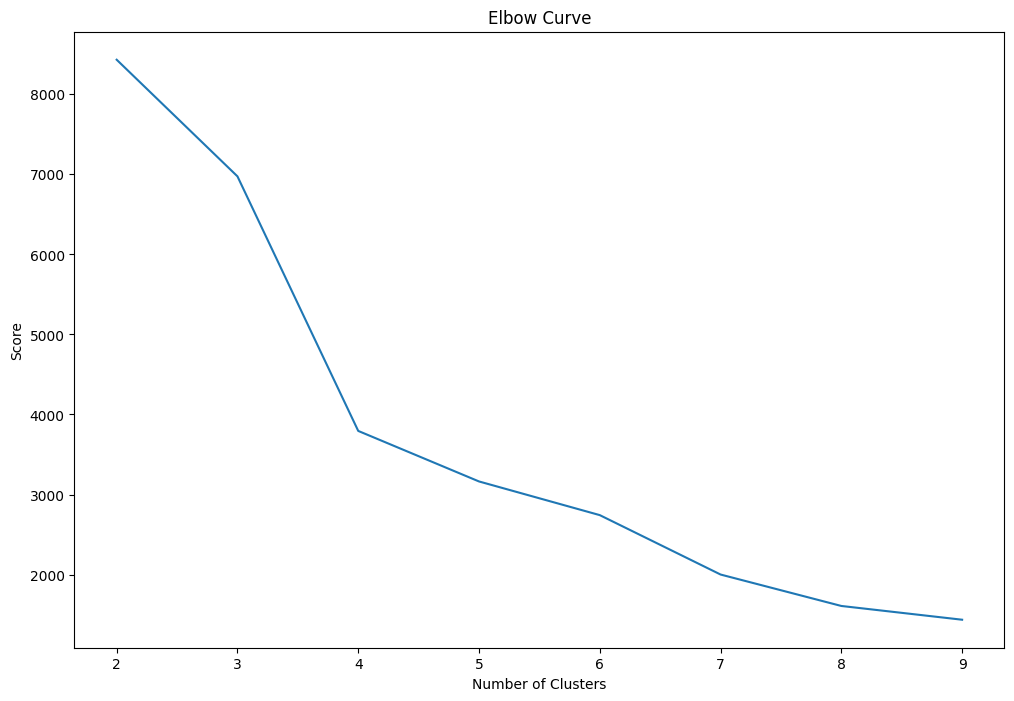

In [ ]:
# Plot the cost
df_cost = pd.DataFrame(costs[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

fig, ax = plt.subplots(1, 1, figsize =(12, 8))
ax.plot(df_cost.cluster, df_cost.cost)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Score')
ax.set_title('Elbow Curve')

Qua đó, chúng ta chọn K = 4

In [ ]:
k_means = KMeans(featuresCol='rfm_standardized', k=4)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

result = predictions.select('CustomerID', 'prediction')

In [ ]:
result.show(5)

+----------+----------+
|CustomerID|prediction|
+----------+----------+
|     15619|         2|
|     17389|         3|
|     14450|         0|
|     15727|         2|
|     15790|         2|
+----------+----------+
only showing top 5 rows



In [ ]:
# convert the result to pandas dataframe
result_pd = result.toPandas()

In [ ]:
# merge the result with the original dataset
clustered = rfm_score_pd.merge(result_pd, on='CustomerID', how='inner')

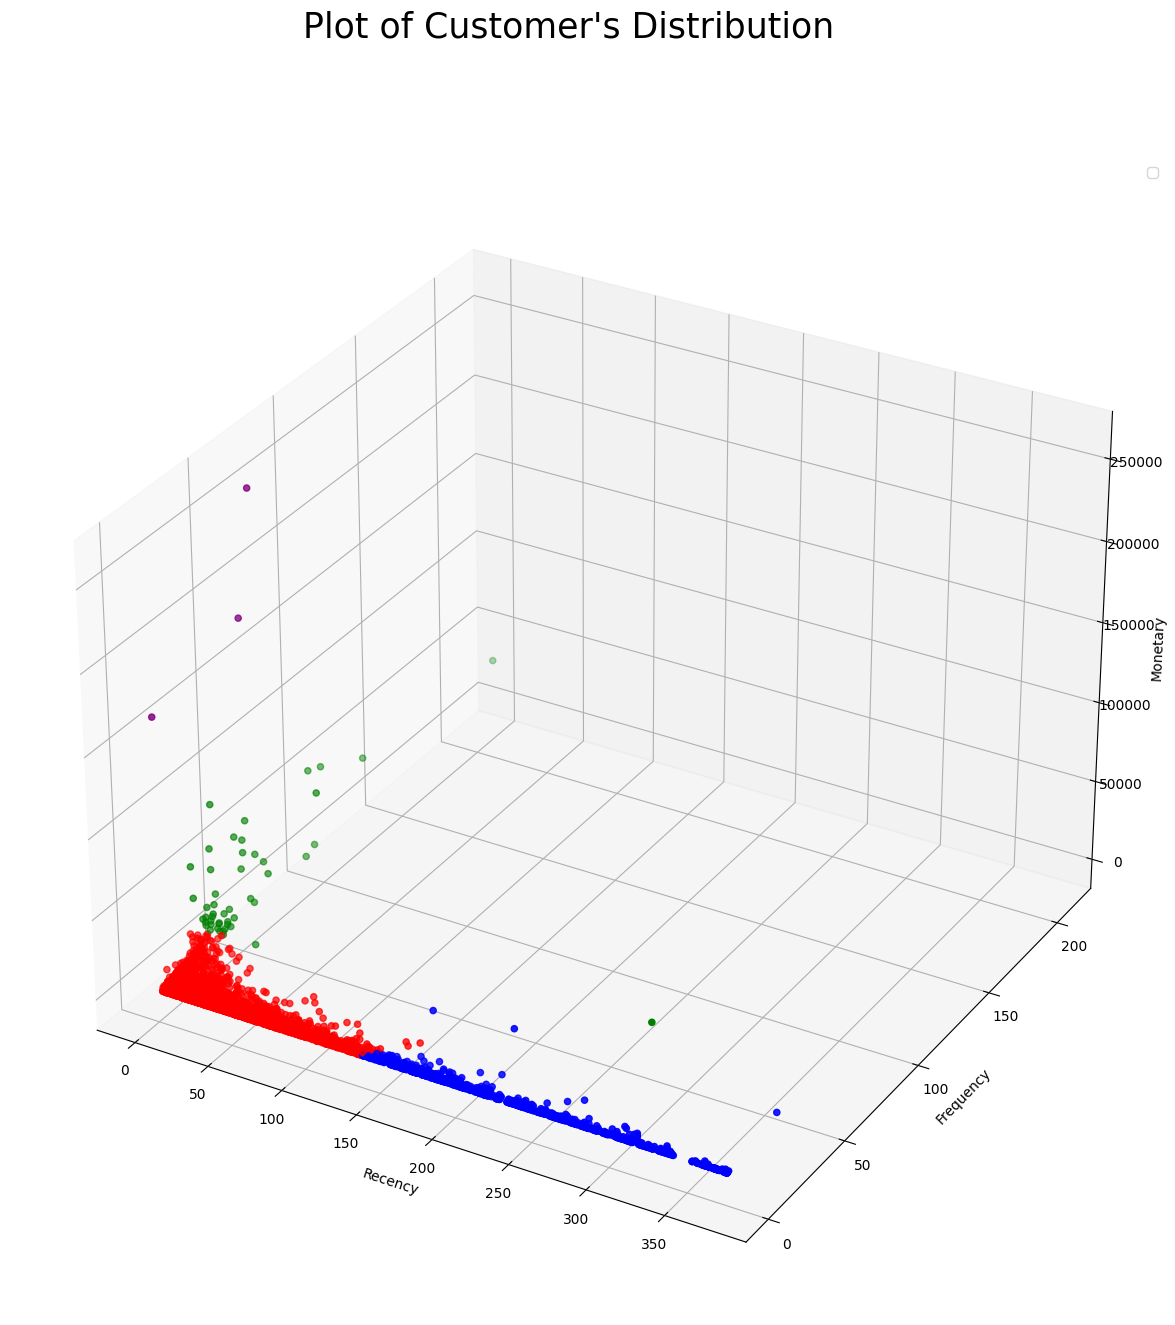

In [ ]:
colors = np.array(["blue", "purple","red","green"])
fig  = plt.figure(figsize = (15,15)).suptitle('Plot of Customer\'s Distribution', fontsize=25)
ax = plt.axes(projection='3d')
ax.scatter3D(clustered["Recency"], clustered["Frequency"], clustered ["Monetary"], marker='o', c=colors[clustered ["prediction"].tolist()])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend()
plt.show()

<AxesSubplot: xlabel='prediction', ylabel='Monetary'>

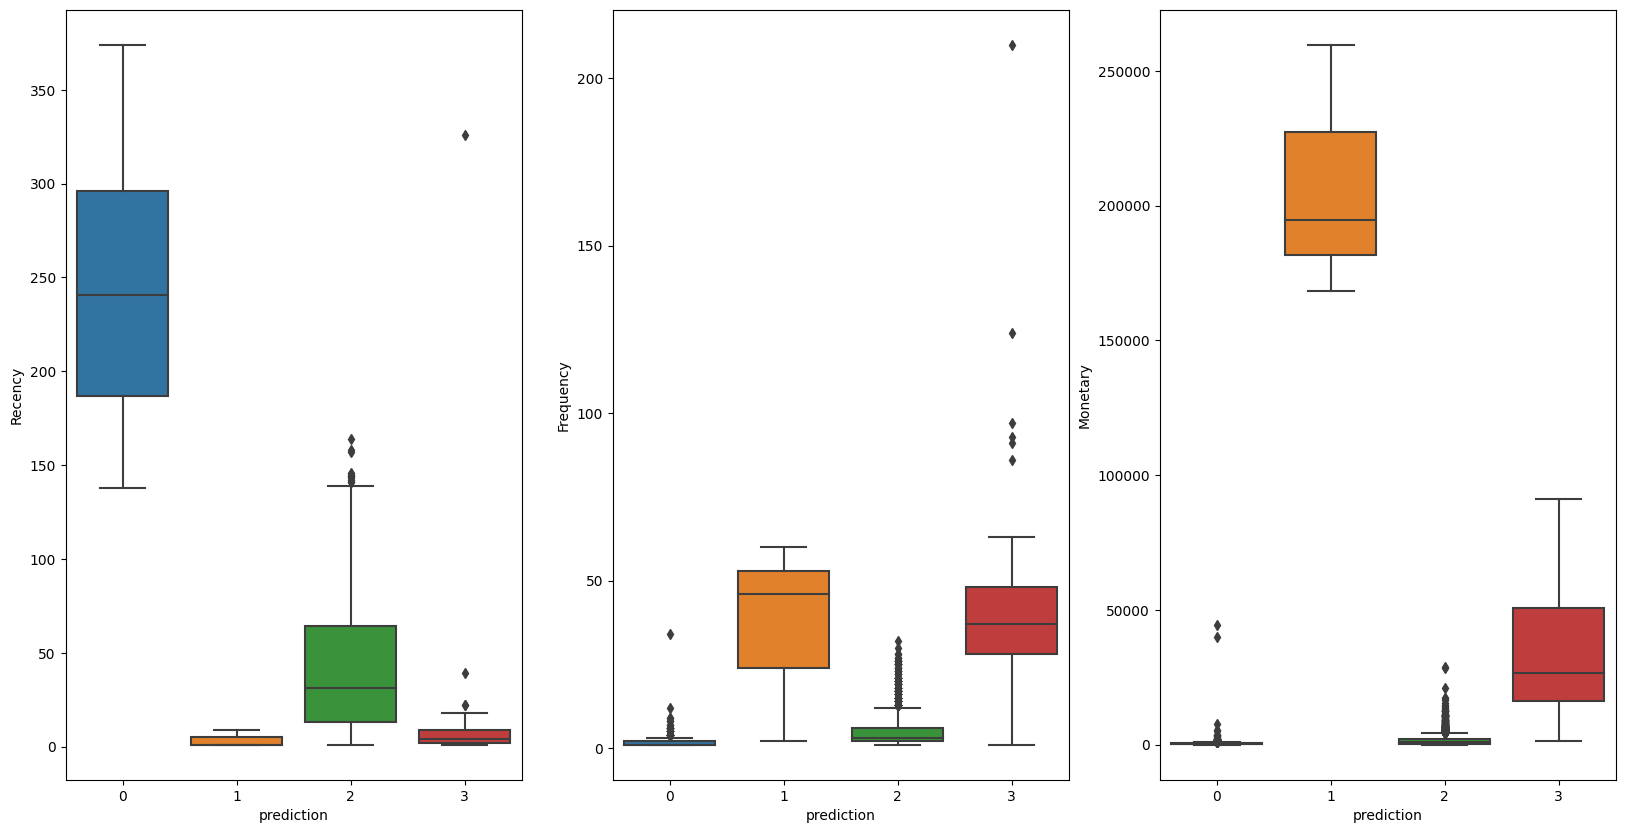

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.boxplot(x='prediction', y='Recency', data=clustered, ax=ax[0])
sns.boxplot(x='prediction', y='Frequency', data=clustered, ax=ax[1])
sns.boxplot(x='prediction', y='Monetary', data=clustered, ax=ax[2])

In [ ]:
Như vậy, tập dữ liệu được phân thành 4 cụm:
    - Cụm 0: nhóm khách hàng có giá trị cao về Recency: đã lâu không mua hàng và số tiền chi trả cho các giao dịch và mức độ thường xuyên rất thấp
    - Cụm 1: nhóm khách hàng có giá trị cao nhất về Frequency và Monetary: tần suất mua hàng cao và số tiền chi trả cho các giao dịch lớn
